In this notebook I am using both, functions that were created specifically for this task, and functions that I have created for different problems.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from collections import Counter
import ast

random_state= 42 #perfect number

# Data Loading

In [2]:
# Load the CSV file into a DataFrame
file_path = 'CSV_malware.csv'
df = pd.read_csv(file_path)
df['pred'] = 1

df.head()

,Country,ASN,TTL,IP,Domain,oc_8,longest_word,Domain_Name,dec_32,subdomain,...,typos,tld,shortened,Registrar,obfuscate_at_sign,Alexa_Rank,3gram,numeric_percentage,puny_coded,pred
0,US,26347.0,14399,67.205.14.183,b'dicrophani.com.',0,hani,DICROPHANI.COM,0,0,...,"[('apple.com', 86), ('adobe.com', 86)]",com,-1.0,Name.com inc.,0,-1.0,"['dic', 'icr', 'cro', 'rop', 'oph', 'pha', 'ha...",0.000000,0,1
1,US,46606.0,14399,70.40.220.126,b'dionneg.com.',0,dio,DIONNEG.COM,0,0,...,"[('g.co', 90), ('qq.com', 86)]",com,-1.0,FastDomain Inc.,0,-1.0,"['dio', 'ion', 'onn', 'nne', 'neg']",0.000000,0,1
2,US,16509.0,3599,15.164.151.80,b'vipprojects.cn.',0,projects,vipprojects.cn,0,0,...,"[('4.cn', 86), ('360.cn', 86)]",cn,-1.0,杭州名商网络有限公司,0,-1.0,"['vip', 'ipp', 'ppr', 'pro', 'roj', 'oje', 'je...",0.000000,0,1
3,US,395954.0,599,23.110.187.67,b'hhj3.cn.',0,hh,hhj3.cn,0,0,...,"[('miitbeian.gov.cn', 86), ('miibeian.gov.cn',...",cn,-1.0,成都西维数码科技有限公司,0,-1.0,"['hhj', 'hj3']",11.111111,0,1
4,US,395954.0,599,23.110.187.67,b'hhj3.cn.',0,hh,hhj3.cn,0,0,...,"[('miitbeian.gov.cn', 86), ('miibeian.gov.cn',...",cn,-1.0,成都西维数码科技有限公司,0,-1.0,"['hhj', 'hj3']",11.111111,0,1


In [3]:
file_path = 'CSV_benign.csv'
df2 = pd.read_csv(file_path, skip_blank_lines=False)
# Reduce the DataFrame to 100k rows, 500k rows is way tooooo much for my machine
df2 = df2.sample(n=100000, random_state=42).reset_index(drop=True)
df2['pred'] = 0

df2.head()

C:\Users\pawel\AppData\Local\Temp\ipykernel_22524\145198118.py:3: DtypeWarning: Columns (9,10,12,13,17,18,20,21,24,25,27,28,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file_path, skip_blank_lines=False)


,Country,ASN,TTL,IP,Domain,State,Registrant_Name,Country.1,Creation_Date_Time,hex_32,...,typos,oc_8,3gram,char_distribution,2gram,Registrar,sld,Name_Server_Count,Page_Rank,pred
0,CN,38365.0,3599,180.76.233.83,b'lxgkj.com.',bei jing,NaN,CN,2008-05-27 02:59:35,0,...,"[('qq.com', 86), ('vk.com', 86)]",0,"['lxg', 'xgk', 'gkj']","defaultdict(<class 'int'>, {'x': 1, 'k': 1, 'j...","['lx', 'xg', 'gk', 'kj']",Xiamen 35.Com Technology Co. Ltd,lxgkj,4.0,-1.0,0
1,US,22612.0,1199,199.188.200.112,b'ganeshamtextilemills.in.',NaN,NaN,NaN,2017-04-06 14:54:00,0,...,"[('google.co.in', 86), ('illinois.edu', 49)]",0,"['gan', 'ane', 'nes', 'esh', 'sha', 'ham', 'am...","defaultdict(<class 'int'>, {'e': 3, 'h': 1, 'i...","['ga', 'an', 'ne', 'es', 'sh', 'ha', 'am', 'mt...",GoDaddy.com LLC,ganeshamtextilemills,2.0,-1.0,0
2,US,13335.0,299,104.27.131.55,b'www.eurobahnm.com.',Arizona,NaN,US,2009-02-24 00:18:44,0,...,0,"[('qq.com', 86), ('vk.com', 86)]",0,"['eur', 'uro', 'rob', 'oba', 'bah', 'ahn', 'hnm']","defaultdict(<class 'int'>, {'e': 1, 'u': 1, 'o...","['eu', 'ur', 'ro', 'ob', 'ba', 'ah', 'hn', 'nm']",GoDaddy.com LLC,eurobahnm,2.0,0
3,US,13335.0,299,104.27.135.232,b'wkm.xyz.',NaN,NaN,NaN,NaN,0,...,"[('ow.ly', 50), ('t.me', 43)]",0,['wkm'],"defaultdict(<class 'int'>, {'m': 1, 'k': 1, 'w...","['wk', 'km']",NaN,wkm,NaN,NaN,0
4,GB,15510.0,14399,91.215.187.64,b'motmasters.co.uk.',NaN,MOT Masters Ltd,NaN,2006-09-27 00:00:00,0,...,"[('t.co', 86), ('bbc.co.uk', 86)]",0,"['mot', 'otm', 'tma', 'mas', 'ast', 'ste', 'te...","defaultdict(<class 'int'>, {'t': 2, 'e': 1, 'o...","['mo', 'ot', 'tm', 'ma', 'as', 'st', 'te', 'er...",Getyouonline.co.uk Ltd t/a Websites4UKGarages....,motmasters,39.0,-1.0,0


In [5]:
#Combine both
dataset = pd.concat([df2, df])

# Pre data processing

Because all of the features were marked as usefull in problem describtion, I won't be deleting them, only changing into numerical.

I tried to perform this task as close possible to how it was done in describtion.

In [6]:
#A lot of data shifts, so in numeric columns whenever there are different values than numeric, i will change them to NaN
def convert_to_numeric(df, numeric_cols):
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
def convert_to_list(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Attempt to evaluate the string as a Python literal expression (list)
        except (ValueError, SyntaxError):
            return np.nan 
    return np.nan 

In [8]:
#Convert to years
def convert_to_years(domain_age_str):
    try:
        days_str = domain_age_str.split(' ')[0]
        days = int(days_str)
        years = days / 365
        return years
    
    except (ValueError, AttributeError, TypeError):
        return np.nan

In [9]:
def label_encode_column(df, column_name):
    # I change NaNs to differnt, 0 category as it might give some information to the model also,
    #I am not sure from where the nans are coming from
    for column in column_name:
        # Use factorize to encode the column
        labels, _ = pd.factorize(df[column], use_na_sentinel=True)

        # Increment the labels by 1 to make room for NaN values to be 0
        df[column] = labels + 1

        # Replace the sentinel value for NaN (which was set to -1 and then incremented to 0) to 0
        df[column].replace(-1 + 1, 0, inplace=True)

In [10]:
def select_one_domain(domain):
    if isinstance(domain, list):
        return domain[0].lower() if domain else None  # Picks the first domain if list is not empty
    elif isinstance(domain, str):
        return domain.lower()
    else:
        return domain

dataset['Domain_Name'] = dataset['Domain_Name'].apply(select_one_domain)

In [11]:
#calc averege of frequency for n-grams
def average_frequency(ngram_list, freq_dict):
    if not isinstance(ngram_list, list):
        return np.nan 
    total_freq = 0
    count = 0
    for ngram in ngram_list:
        if not isinstance(ngram, str):  # Ignore non-string 1-grams
            continue
        total_freq += freq_dict.get(ngram, 0)  # Get frequency from dictionary
        count += 1
    return total_freq / count if count > 0 else np.nan  # Compute average

In [12]:
#How many inicial NaN values
dataset.isna().sum()

Country                22978
ASN                    22966
TTL                        0
IP                     22694
Domain                     0
State                  58467
Registrant_Name       102136
Country.1              50848
Creation_Date_Time     28060
hex_32                    21
hex_8                      0
Domain_Name            20831
Alexa_Rank             11712
subdomain                  4
Organization           61835
len                       68
longest_word              28
oc_32                      3
shortened                333
1gram                      1
obfuscate_at_sign          0
entropy                    1
Domain_Age             11711
tld                        1
dec_8                      3
dec_32                    23
Emails                 36314
numeric_percentage       162
puny_coded                 0
typos                      0
oc_8                       0
3gram                      0
char_distribution          0
2gram                     42
Registrar     

In [13]:
dataset.columns

Index(['Country', 'ASN', 'TTL', 'IP', 'Domain', 'State', 'Registrant_Name',
       'Country.1', 'Creation_Date_Time', 'hex_32', 'hex_8', 'Domain_Name',
       'Alexa_Rank', 'subdomain', 'Organization', 'len', 'longest_word',
       'oc_32', 'shortened', '1gram', 'obfuscate_at_sign', 'entropy',
       'Domain_Age', 'tld', 'dec_8', 'dec_32', 'Emails', 'numeric_percentage',
       'puny_coded', 'typos', 'oc_8', '3gram', 'char_distribution', '2gram',
       'Registrar', 'sld', 'Name_Server_Count', 'Page_Rank', 'pred'],
      dtype='object')

In [14]:
#Change those columns to be ONLY numeric
numeric_columns = ['ASN', 'TTL', 'Alexa_Rank', 'subdomain', 'len', 'shortened', 'obfuscate_at_sign', 'entropy', 'numeric_percentage', 'puny_coded', 'Name_Server_Count', 'Page_Rank']
convert_to_numeric(dataset, numeric_columns)

In [15]:
#Change those columns from categorical to continuous values
label_encode_column(dataset, ["Country", "IP", "Domain", "State", "Registrant_Name", "Country.1", "Domain_Name", "Organization", 'longest_word', 'tld', 'Emails', 'typos', 'Registrar', 'sld'])

In [16]:
#Calculate seconds
dataset['Creation_Date_Time'] = pd.to_datetime(dataset['Creation_Date_Time'], errors='coerce')
dataset['Creation_Date_Time'] = (dataset['Creation_Date_Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [17]:
#Convert to years
dataset["Domain_Age"] = [convert_to_years(value) for value in dataset["Domain_Age"]]

In [18]:
#grams to lists
dataset["1gram"] = [convert_to_list(value) for value in dataset["1gram"]]
dataset["2gram"] = [convert_to_list(value) for value in dataset["2gram"]]
dataset["3gram"] = [convert_to_list(value) for value in dataset["3gram"]]

In [19]:
#handling n-grams
#calc freq of all n-grams
def calc_freq(df, col_name):
    flattened_grams = [gram for sublist in df[f"{col_name}"] if isinstance(sublist, list) for gram in sublist if isinstance(gram, str)]
    frequency_counter = Counter(flattened_grams)
    frequency_dict = dict(frequency_counter)
    return frequency_dict

freq1 = calc_freq(dataset, "1gram")
freq2 = calc_freq(dataset, "2gram")
freq3 = calc_freq(dataset, "3gram")
#calculate average of earlier calculated frequency for every n-gram
dataset["1gram"] = dataset["1gram"].apply(lambda x: average_frequency(x, freq1))
dataset["2gram"] = dataset["2gram"].apply(lambda x: average_frequency(x, freq2))
dataset["3gram"] = dataset["3gram"].apply(lambda x: average_frequency(x, freq3))

In [20]:
obfuscation = ['hex_8', 'hex_32', 'oc_32', 'dec_8', 'dec_32', 'oc_8']
convert_to_numeric(dataset, obfuscation)

In [21]:
for col in obfuscation:
    print(f"{col}: {dataset[col].unique()}")

hex_8: [ 0. nan]
hex_32: [ 0. nan  1.]
oc_32: [ 0. nan -1.  1.  3.  9.  5.  2.]
dec_8: [ 0. nan]
dec_32: [ 0.  1. nan]
oc_8: [ 0. nan]


In [22]:
#deal with different values than bollean
def filter_bool_and_nan(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: int(1) if x == 1.0 else int(0) if x == 0.0 else np.nan if pd.isna(x) else np.nan)

filter_bool_and_nan(dataset, obfuscation)

In [23]:
for col in obfuscation:
    print(f"{col}: {dataset[col].unique()}")

hex_8: [ 0. nan]
hex_32: [ 0. nan  1.]
oc_32: [ 0. nan  1.]
dec_8: [ 0. nan]
dec_32: [ 0.  1. nan]
oc_8: [ 0. nan]


In [24]:
#Combine into one
dataset['obfuscation'] = dataset[['hex_8', 'hex_32', 'oc_32', 'dec_8', 'dec_32', 'oc_8']].max(axis=1)

In [25]:
dataset.drop(columns=['char_distribution', 'hex_8', 'hex_32', 'oc_32', 'dec_8', 'dec_32', 'oc_8'], inplace = True)
# char_distribution already in 1gram, which i calculated
# rest is combined into obfuscation column

In [26]:
#replace all NaN values
dataset.fillna(0, inplace=True)

In [27]:
dataset.isna().sum()

Country               0
ASN                   0
TTL                   0
IP                    0
Domain                0
State                 0
Registrant_Name       0
Country.1             0
Creation_Date_Time    0
Domain_Name           0
Alexa_Rank            0
subdomain             0
Organization          0
len                   0
longest_word          0
shortened             0
1gram                 0
obfuscate_at_sign     0
entropy               0
Domain_Age            0
tld                   0
Emails                0
numeric_percentage    0
puny_coded            0
typos                 0
3gram                 0
2gram                 0
Registrar             0
sld                   0
Name_Server_Count     0
Page_Rank             0
pred                  0
obfuscation           0
dtype: int64

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104999 entries, 0 to 4998
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             104999 non-null  int64  
 1   ASN                 104999 non-null  float64
 2   TTL                 104999 non-null  float64
 3   IP                  104999 non-null  int64  
 4   Domain              104999 non-null  int64  
 5   State               104999 non-null  int64  
 6   Registrant_Name     104999 non-null  int64  
 7   Country.1           104999 non-null  int64  
 8   Creation_Date_Time  104999 non-null  float64
 9   Domain_Name         104999 non-null  int64  
 10  Alexa_Rank          104999 non-null  float64
 11  subdomain           104999 non-null  float64
 12  Organization        104999 non-null  int64  
 13  len                 104999 non-null  float64
 14  longest_word        104999 non-null  int64  
 15  shortened           104999 non-null 

In [29]:
dataset.head()

,Country,ASN,TTL,IP,Domain,State,Registrant_Name,Country.1,Creation_Date_Time,Domain_Name,...,puny_coded,typos,3gram,2gram,Registrar,sld,Name_Server_Count,Page_Rank,pred,obfuscation
0,1,38365.0,3599.0,1,1,1,0,1,1.211857e+09,1,...,0.0,1,1.666667,84.000000,1,1,4.0,-1.0,0,0.0
1,2,22612.0,1199.0,2,2,0,0,0,1.491490e+09,2,...,0.0,2,333.500000,4755.526316,2,2,2.0,-1.0,0,0.0
2,2,13335.0,299.0,3,3,2,0,2,1.235435e+09,3,...,0.0,3,0.000000,0.000000,3,3,0.0,2.0,0,0.0
3,2,13335.0,299.0,4,4,0,0,0,0.000000e+00,0,...,0.0,4,3.000000,157.000000,0,4,0.0,0.0,0,0.0
4,3,15510.0,14399.0,5,5,0,1,0,1.159315e+09,4,...,0.0,5,983.875000,6163.888889,4,5,39.0,-1.0,0,0.0


## Split data

In [30]:
#preparnig some small test data
test_1 = dataset[dataset['pred'] == 1].sample(n=50, random_state=random_state)
test_0 = dataset[dataset['pred'] == 0].sample(n=50, random_state=random_state)

In [31]:
dataset.drop(test_0.index, inplace = True)

In [32]:
dataset.drop(test_1.index, inplace = True)

### train split

In [33]:
y = dataset['pred']
X = dataset.drop('pred', 1)

C:\Users\pawel\AppData\Local\Temp\ipykernel_22524\3267320787.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = dataset.drop('pred', 1)


In [34]:
# stratified 5 fold with shuffle
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Building

In [80]:
#functions were made by me from other projects

In [35]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.set_title('Learning Curve')
    ax.legend(loc='best', fontsize=14);

In [38]:
def score_and_plot(model, X, y, cv):
    print(f"accuracy: {np.round(model.best_score_, 3)}\n"
      f"precision +/-: {np.mean(model.cv_results_['mean_test_precision'])}\n"
      f"recall +/-: {np.mean(model.cv_results_['mean_test_recall'])}\n"
      f"f1-score +/-: {np.mean(model.cv_results_['mean_test_f1'])}\n")
#      f"possible only 1's: {np.mean(np.mean(model.cv_results_['split0_test_precision']) + np.mean(model.cv_results_['split1_test_precision']) + np.mean(model.cv_results_['split2_test_precision']) + np.mean(model.cv_results_['split3_test_precision']) + np.mean(model.cv_results_['split4_test_precision']))}")
    
    fig, ax1 = plt.subplots(1, figsize=(5, 3))
    plot_learning_curve(model.best_estimator_, X, y, ax = ax1, cv = cv)

## SVC

In [39]:
svc = SVC(probability=True, random_state=random_state)

param_grid = [{'clf__kernel': ['rbf'],
              'clf__C': [1]},
            ]

#pipeline that will scale data
pipe_svc = Pipeline([
        ('scale', MinMaxScaler()),
        ('clf', svc)])

In [40]:
svc_clf = GridSearchCV(pipe_svc, cv=stratified_kfold,
                        param_grid=param_grid, scoring=["accuracy", "precision", "recall", "f1"],
                      refit = "accuracy",
                      n_jobs=-1, verbose = 0)

#train
best_svc = svc_clf.fit(X, y)
best_svc.best_params_

{'clf__C': 1, 'clf__kernel': 'rbf'}

### results

accuracy: 0.991
precision +/-: 0.933259517594563
recall +/-: 0.8827098078867543
f1-score +/-: 0.9072630836847899



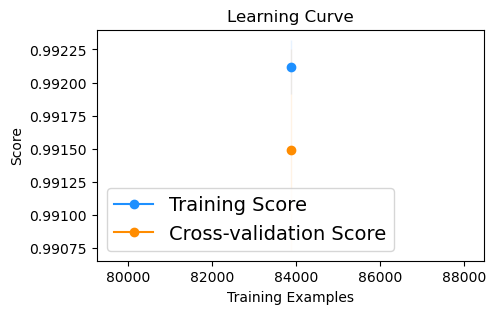

In [41]:
score_and_plot(best_svc, X, y, stratified_kfold)

## KNN

In [44]:
knn = KNeighborsClassifier()

param_grid = {'clf__n_neighbors': [3, 4, 5, 6],
             'clf__weights': ['uniform', 'distance']}

pipe_knn = Pipeline([
        ('scale', MinMaxScaler()),
        ('clf', knn)])

knn_clf = GridSearchCV(pipe_knn, cv=stratified_kfold,
                        param_grid=param_grid, scoring=["accuracy", "precision", "recall", "f1"],
                      refit = "accuracy", return_train_score= True,
                      n_jobs=-1, verbose = 2)

best_knn = knn_clf.fit(X, y)
best_knn.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'clf__n_neighbors': 6, 'clf__weights': 'distance'}

### results

accuracy: 0.986
precision +/-: 0.8642254715959619
recall +/-: 0.7840242669362993
f1-score +/-: 0.8208894063260763



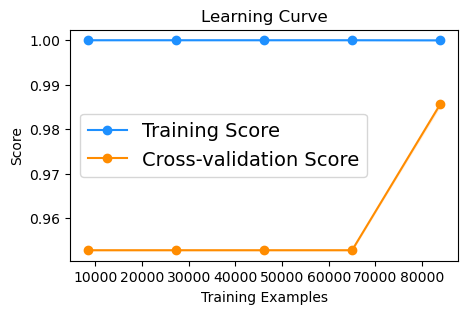

In [45]:
score_and_plot(best_knn, X, y, stratified_kfold)

## XGBoost

In [48]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [5, 6, 7],
    'clf__scale_pos_weight': [5, 20]
}

pipe_xgb = Pipeline([
        ('scale', MinMaxScaler()),
        ('clf', xgb)])

xgb_clf = GridSearchCV(pipe_xgb, cv=stratified_kfold,
                        param_grid=param_grid, scoring=["accuracy", "precision", "recall", "f1"],
                      refit = "accuracy", return_train_score= True,
                      n_jobs=-1, verbose = 2)

best_xgb = xgb_clf.fit(X, y)
best_xgb.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 5}

### results

accuracy: 1.0
precision +/-: 0.9960642783019247
recall +/-: 0.9944051230198853
f1-score +/-: 0.9952325602111851



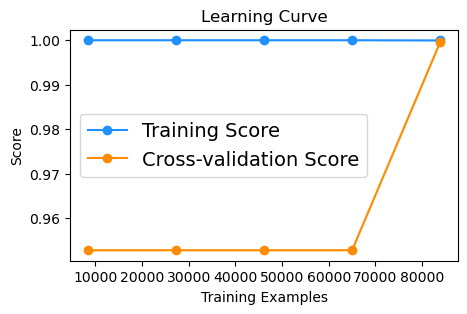

In [49]:
score_and_plot(best_xgb, X, y, stratified_kfold)

## ROC Curve

Plotting ROC curve

In [67]:
def plot_cross_val_ROC(model, X, y, cv, title):
    predicted_probabilities = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

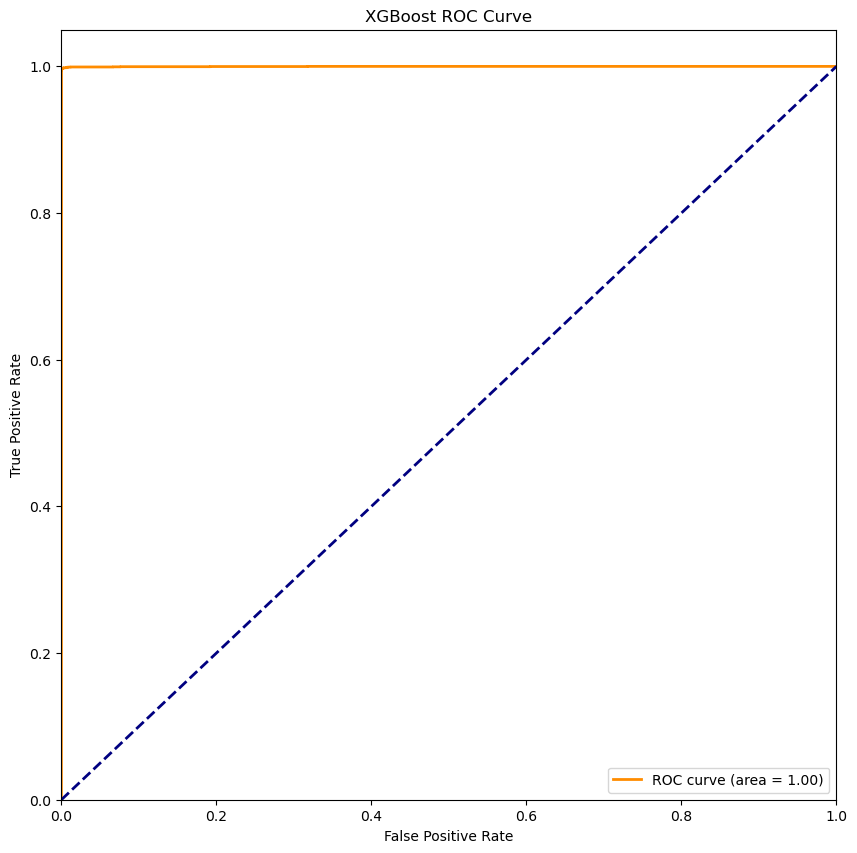

In [68]:
plot_cross_val_ROC(best_xgb.best_estimator_, X, y, stratified_kfold, 'XGBoost ROC Curve')

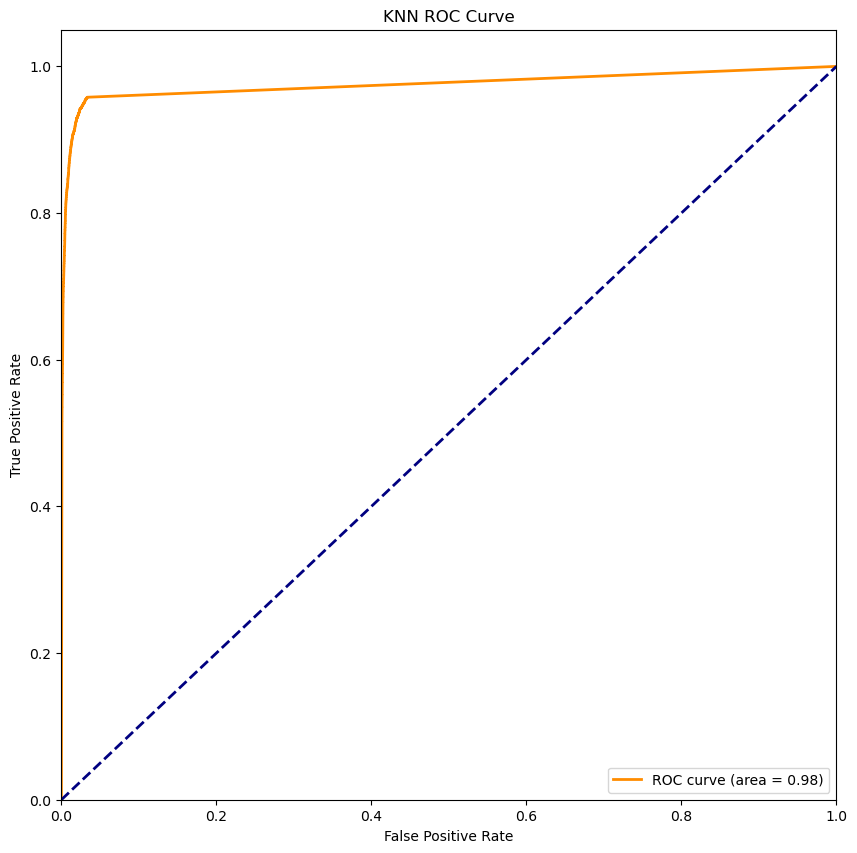

In [69]:
plot_cross_val_ROC(best_knn.best_estimator_, X, y, stratified_kfold, 'KNN ROC Curve')

In [71]:
#Didn't have time to plot this :(
#plot_cross_val_ROC(best_svc.best_estimator_, X, y, stratified_kfold, 'SVC ROC Curve')

Not a lot of new information from ROC curve other than that models are working

## Feature Importance

In [60]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X.columns,
                                'Importance': np.round(classifier.best_estimator_.named_steps['clf'].feature_importances_, 3)})
    
    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

C:\Users\pawel\AppData\Local\Temp\ipykernel_22524\2633817074.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, i + 1)


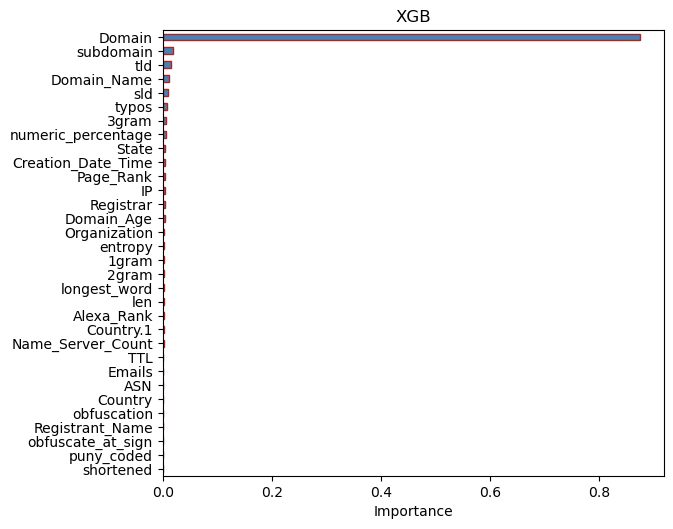

In [61]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(1, 1, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['XGB'],
                                    [best_xgb])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

For XGB model MOST important feature "Domain", rest is pretty negligible

# Test

Here I am performing simple test from data earlier saved to see how well models will work.

For production (unseen) true data the model should work like presented in this step.
Note: New unseen data would have to be preprocessed the same way as I did for this dataset.

In [72]:
def calculate_classification_parameters(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = metrics.recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = metrics.f1_score(y_true, y_pred, average='binary', zero_division=1)
    
    results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    }
    return print(results)

In [73]:
test = pd.concat([test_1, test_0])

In [74]:
#Shuffling test data
test = test.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [75]:
y_test = test['pred']
X_test = test.drop('pred', 1)
y_test

C:\Users\pawel\AppData\Local\Temp\ipykernel_22524\2119818756.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop('pred', 1)


0     0
1     0
2     0
3     1
4     1
     ..
95    0
96    0
97    1
98    0
99    0
Name: pred, Length: 100, dtype: int64

## SVC

In [76]:
prediction_SVC = best_svc.predict(X_test)

calculate_classification_parameters(y_test, prediction_SVC)

{'Accuracy': 0.95, 'Precision': 1.0, 'Recall': 0.9, 'F1 Score': 0.9473684210526316}


## KNN

In [78]:
prediction_KNN = best_knn.predict(X_test)

calculate_classification_parameters(y_test, prediction_KNN)

{'Accuracy': 0.89, 'Precision': 1.0, 'Recall': 0.78, 'F1 Score': 0.8764044943820225}


XGB

In [79]:
prediction_XGB = best_xgb.predict(X_test)

calculate_classification_parameters(y_test, prediction_XGB)

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


# Conclusions

Best results for XGBoost. For unseen (test) data it presents astonishing 100% accuracy.